In [1]:
from ortools.graph import pywrapgraph
import numpy as np
np.random.seed(123456789)

from tqdm import tqdm

import cv2 as cv

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

from matplotlib import image
from matplotlib.patches import ConnectionPatch


In [2]:
def dist(x, y):
    d =  np.linalg.norm(x - y) ** 2
    return d if d > 0 else 1e-10

def greedy(X, X_hash, num_to_match=None, return_cost=False, progress_bar=False):
    costs = [0]
    cost = 0
    if num_to_match is None:
        num_to_match = len(X)
    n, m = len(X), len(X_hash)
    M = np.zeros((n, m))
    if progress_bar:
        iterable = tqdm(enumerate(X), desc='Calculating pairwise distances', total=n)
    else:
        iterable = enumerate(X)
    for i, x in iterable:
        for j, x_hash in enumerate(X_hash):
            M[i, j] = dist(x, x_hash)
    pie = -1 * np.ones(n, dtype=np.int32)
    for _ in range(num_to_match):
        i, j = np.unravel_index(M.argmin(), M.shape)
        pie[i] = j
        cost += M[i, j]
        costs.append(cost)
        M[:, j] = np.inf
        M[i, :] = np.inf

    if return_cost:
        return pie, costs

    return pie


def MinCostFlow(X, X_hash, num_to_match = None, scale = 1000, sigma=None, return_cost=False):
    n, m = (len(X), len(X_hash))
    M = np.zeros(n * m)
    for i, x in enumerate(X):
        for j, x_hash in enumerate(X_hash):
            M[i * m + j] = dist(x, x_hash)
        
    if sigma is not None:
        M = M / 2 / sigma / sigma
    
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    
    start_nodes = np.concatenate((np.zeros(n), 
                                  np.repeat(np.arange(1, n + 1), m), 
                                  np.arange(n + 1, n + m + 1))).astype(int).tolist()
    
    end_nodes = np.concatenate((np.arange(1, n + 1), 
                                np.tile(np.arange(n + 1, n + m + 1), n), 
                                np.ones(m) * (n + m + 1))).astype(int).tolist()
    
    num_overall_edges = (n + 1) * (m + 1) - 1
    capacities = np.ones(num_overall_edges).astype(int).tolist()
    costs = (np.concatenate((np.zeros(n), M * scale ,np.zeros(m))).astype(int).tolist())
    
    source = 0
    sink = n + m + 1
    if num_to_match is None:
        num_to_match = n
    
    supplies = [num_to_match] + [0] * (n + m) + [-num_to_match]
    
    # Add each arc.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i],
                                                    end_nodes[i], capacities[i],
                                                    costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    
    status = min_cost_flow.Solve()
    assignment = -1 * np.ones(n, dtype=np.int32)
    if status == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
            # Can ignore arcs leading out of source or into sink.
            if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(arc) != sink:
                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if min_cost_flow.Flow(arc) > 0:
                    assignment[min_cost_flow.Tail(arc) - 1] = min_cost_flow.Head(arc) - n - 1
        
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')

    if return_cost:
        return assignment, min_cost_flow.OptimalCost() / scale
    else:
        return assignment



In [3]:
def create_pair(pic, skip_kps = 4, n=50, k=20):
    new_x = pic.shape[0] // 2
    new_y = pic.shape[1] // 2 
    crop = pic[:new_x, :new_y, :]
    crop = cv.resize(crop, dsize=(pic.shape[1] , pic.shape[0]), interpolation=cv.INTER_CUBIC)
    
    sift = cv.SIFT_create(contrastThreshold=0.1, edgeThreshold=0.5)
    crop_kps = sift.detect(crop, None)[::skip_kps]

    if len(crop_kps) < n + k:
        raise ValueError('Not Enough KPS')
        
    pic_kps = []
    for kp in crop_kps:
        pic_kps.append(cv.KeyPoint(kp.pt[0] / 2, kp.pt[1] / 2,  kp.size / 2, kp.angle, kp.response, kp.octave, kp.class_id))

    rand_perm = np.random.permutation(len(crop_kps))
    pic_kps = [pic_kps[i] for i in rand_perm[:n]]
    crop_kps = [crop_kps[i] for i in rand_perm[:k]] + [crop_kps[i] for i in rand_perm[k-n:]]

    pic_kps, pic_desc = sift.compute(pic, pic_kps)
    crop_kps, crop_desc = sift.compute(crop, crop_kps)
    
    return pic, crop, pic_kps, crop_kps, pic_desc, crop_desc


In [4]:
def show_pair(pic1, pic2, kps1, kps2, pie=None, save_name=None):
    pic1 = pic1[:, :, [2, 1, 0]]
    pic2 = pic2[:, :, [2, 1, 0]]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 12))
    ax[0].imshow(pic1)
    ax[1].imshow(pic2)
    ax[0].axis('off')
    ax[1].axis('off')
    
    plt.tight_layout()
    
    if pie is not None:
        for i, j in enumerate(pie):
            if j == -1 or i == j:
                continue
            con = ConnectionPatch(xyA=kps1[i].pt, xyB=kps2[pie[i]].pt, coordsA="data", coordsB="data",
                                  axesA=ax[0], axesB=ax[1], color="red")
            ax[1].add_artist(con)
            
    if pie is not None:
        for i, j in enumerate(pie):
            if j == -1 or i != j:
                continue
            con = ConnectionPatch(xyA=kps1[i].pt, xyB=kps2[pie[i]].pt, coordsA="data", coordsB="data",
                                  axesA=ax[0], axesB=ax[1], color="green")
            ax[1].add_artist(con)
    
    if save_name is not None:
        plt.savefig(save_name, dpi=100)

In [5]:
def lambda_nmda(n, m, d, alpha = 0.001):
    return 4 * max(np.power(d * np.log(4 * n * m / alpha), 1 / 4),
                   np.power(8 * np.log(4 * n * m / alpha), 1 / 2))

def k_sig_joint_est(X, X_hash, progress_bar=True, matcher=greedy):
    n = len(X)
    m = len(X_hash)
    d = len(X[0])
    lambda_nmd = lambda_nmda(n, m, d)
    lbd = np.square(lambda_nmd) / 4
    gamma = lbd / d
    res = {}
    
    _, costs = matcher(X, X_hash, num_to_match=n, return_cost=True, progress_bar=progress_bar)
    
    for k in range(1, n):
        sigma_hat_sq = costs[k] / k / d
        if costs[k + 1] - costs[k] > (d + lbd) * sigma_hat_sq / abs(1 - gamma):
            res['k_alpha'] = k
            res['sigma_hat'] = np.sqrt(sigma_hat_sq / 2)
            return res, costs
            
    res['k_alpha'] = n
    res['sigma_hat'] = np.sqrt(sigma_hat_sq / 2)
    return res, costs

In [6]:
pic = cv.imread('sacre.jpg')
pic = cv.resize(pic, dsize=(pic.shape[1] // 2 , pic.shape[0] // 2))

In [7]:
pic, crop, pic_kps, crop_kps, pic_desc, crop_desc = create_pair(pic, skip_kps=1, n=50, k=25)
r, costs = k_sig_joint_est(pic_desc, crop_desc)
print(f"Estimated Number of Inliers: {r['k_alpha']} (Real Number Of Inliers = 25)")

Calculating pairwise distances: 100%|█████████| 50/50 [00:00<00:00, 2166.23it/s]

Estimated Number of Inliers: 22 (Real Number Of Inliers = 25)


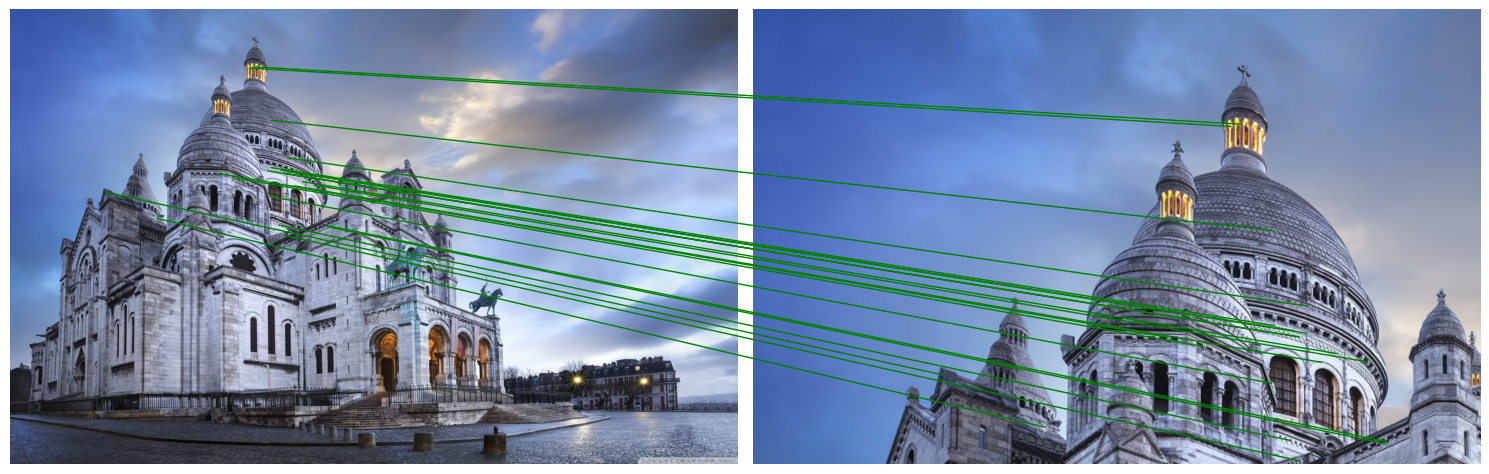

In [8]:
pie = MinCostFlow(pic_desc, crop_desc, num_to_match=r['k_alpha'])
show_pair(pic, crop, pic_kps, crop_kps, pie, save_name='scoeur_50_25.pdf')

In [9]:
pic, crop, pic_kps, crop_kps, pic_desc, crop_desc = create_pair(pic, skip_kps=1, n=100, k=50)
r, costs = k_sig_joint_est(pic_desc, crop_desc)
print(f"Estimated Number of Inliers: {r['k_alpha']} (Real Number Of Inliers = 50)")

Calculating pairwise distances: 100%|████████| 100/100 [00:00<00:00, 901.00it/s]

Estimated Number of Inliers: 44 (Real Number Of Inliers = 50)


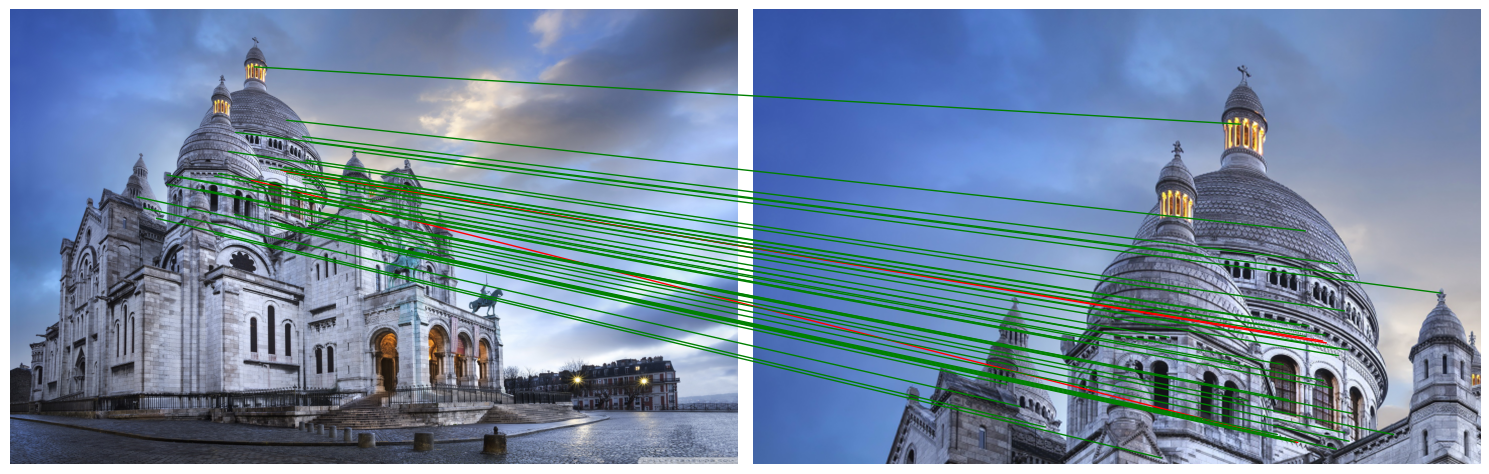

In [10]:
pie = MinCostFlow(pic_desc, crop_desc, num_to_match=r['k_alpha'])
show_pair(pic, crop, pic_kps, crop_kps, pie, save_name='scoeur_100_50.pdf')

In [11]:
pic, crop, pic_kps, crop_kps, pic_desc, crop_desc = create_pair(pic, skip_kps=1, n=350, k=250)
r, costs = k_sig_joint_est(pic_desc, crop_desc)
print(f"Estimated Number of Inliers: {r['k_alpha']} (Real Number Of Inliers = 250)")

Calculating pairwise distances: 100%|████████| 350/350 [00:01<00:00, 252.63it/s]

Estimated Number of Inliers: 213 (Real Number Of Inliers = 250)


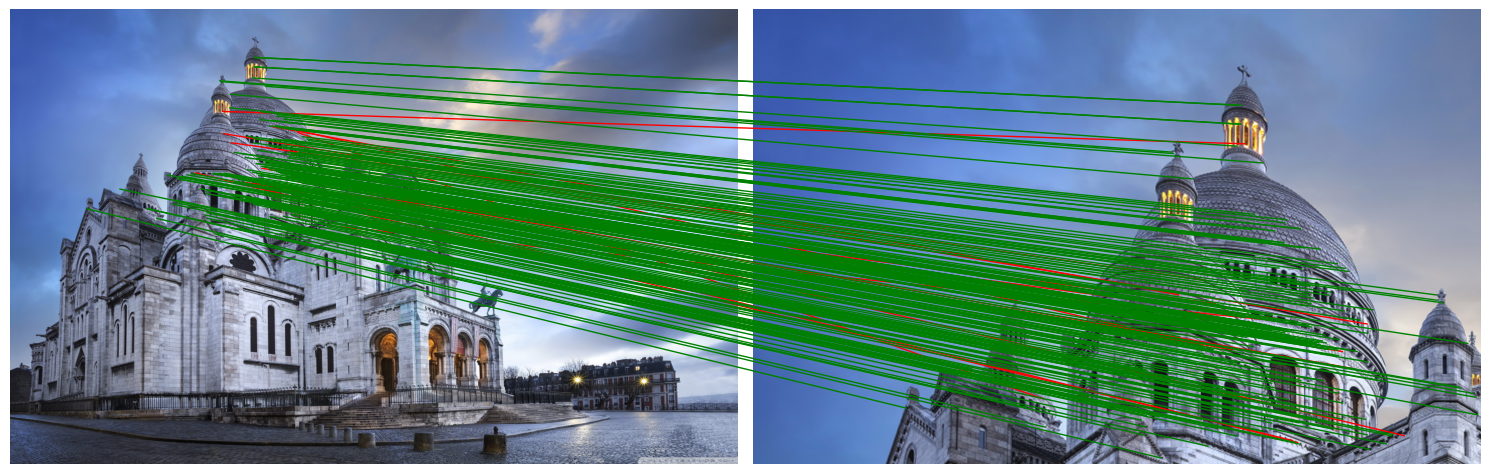

In [12]:
pie = MinCostFlow(pic_desc, crop_desc, num_to_match=r['k_alpha'])
show_pair(pic, crop, pic_kps, crop_kps, pie, save_name='scoeur_350_250.pdf')